In [2]:
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.aadforest import AADForest
from coniferest.label import Label
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from progressbar import progressbar
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor
from copy import deepcopy
from threadpoolctl import threadpool_info, threadpool_limits
from glob import glob

In [3]:
threadpool_limits(limits=1)

In [4]:
threadpool_info()

[{'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 1,
  'prefix': 'libscipy_openblas',
  'filepath': '/media/emille/git/SNAD/venv/snad_3.12/lib/python3.12/site-packages/numpy.libs/libscipy_openblas64_-fdde5778.so',
  'version': '0.3.30',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'num_threads': 1,
  'prefix': 'libscipy_openblas',
  'filepath': '/media/emille/git/SNAD/venv/snad_3.12/lib/python3.12/site-packages/scipy.libs/libscipy_openblas-b75cc656.so',
  'version': '0.3.29.dev',
  'threading_layer': 'pthreads',
  'architecture': 'SkylakeX'},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'num_threads': 1,
  'prefix': 'libgomp',
  'filepath': '/media/emille/git/SNAD/venv/snad_3.12/lib/python3.12/site-packages/scikit_learn.libs/libgomp-e985bcbb.so.1.0.0',
  'version': None}]

## Data

In [5]:
# read data
data = pd.read_parquet('/media/snad/data/gz2/astronomaly.parquet')

In [6]:
data.shape

(61578, 32)

In [7]:
np.unique(data['anomaly'].values, return_counts=True)

(array([False,  True]), array([60654,   924]))

In [8]:
# percentage of anomalies
tag, freq = np.unique(data['anomaly'].values, return_counts=True)
print('Percentage of anomalies = ', np.round(100*freq[1]/freq[0], 3), '%')

Percentage of anomalies =  1.523 %


In [9]:
# remove columns related to ID and anomaly tag
data_use = data

In [10]:
# check for small variaety in floats and percentage of NaNs
for name in data_use.keys():
    n = np.unique(data_use[name].values).shape[0]
    count, freq = np.unique(data_use[name].values, return_counts=True)
    if np.isnan(count).any():
        indx = np.arange(len(count))[np.isnan(count)]
        print(name, n, 'perc_nan =', np.round(100*freq[indx[0]]/data_use.shape[0],3), '%')
    if n < 5:
          print(name, np.unique(data_use[name].values, return_counts=True)
               )

Residual_90 1307 perc_nan = 1.874 %
Residual_80 2490 perc_nan = 1.874 %
Residual_70 3712 perc_nan = 1.874 %
Residual_60 4984 perc_nan = 1.874 %
Residual_50 6275 perc_nan = 1.874 %
Residual_0 17575 perc_nan = 1.874 %
Offset_90 2 perc_nan = 1.874 %
Offset_90 (array([ 0., nan]), array([60424,  1154]))
Offset_80 60425 perc_nan = 1.874 %
Offset_70 60425 perc_nan = 1.874 %
Offset_60 60425 perc_nan = 1.874 %
Offset_50 60425 perc_nan = 1.874 %
Offset_0 60425 perc_nan = 1.874 %
Aspect_90 2 perc_nan = 1.874 %
Aspect_90 (array([ 1., nan]), array([60424,  1154]))
Aspect_80 60425 perc_nan = 1.874 %
Aspect_70 60425 perc_nan = 1.874 %
Aspect_60 60425 perc_nan = 1.874 %
Aspect_50 60425 perc_nan = 1.874 %
Aspect_0 60425 perc_nan = 1.874 %
Theta_90 2 perc_nan = 1.874 %
Theta_90 (array([ 0., nan]), array([60424,  1154]))
Theta_80 59754 perc_nan = 1.874 %
Theta_70 59972 perc_nan = 1.874 %
Theta_60 60019 perc_nan = 1.874 %
Theta_50 60116 perc_nan = 1.874 %
Theta_0 60262 perc_nan = 1.874 %
Maj_90 60424 perc

In [11]:
# remove categorical variables hinden in floats
to_remove = ['Offset_90', 'Aspect_90', 'Theta_90']
names = list(data_use.keys())

for item in to_remove:
    names.remove(item)

In [12]:
# remove NaNs
data_use2 = deepcopy(data_use)[names]

flag = np.array([True for item in range(data_use2.shape[0])])
for item in names:
    flag_item = np.isnan(data_use2[item].values)
    flag = np.logical_and(flag, ~flag_item)

data_use3 = deepcopy(data_use2)[flag]

In [13]:
# check result
# check for small variaety in floats and percentage of NaNs
for name in data_use3.keys():
    n = np.unique(data_use3[name].values).shape[0]
    count, freq = np.unique(data_use3[name].values, return_counts=True)
    if np.isnan(count).any():
        indx = np.arange(len(count))[np.isnan(count)]
        print(name, n, 'perc_nan =', np.round(100*freq[indx[0]]/data_use3.shape[0],3), '%')
    if n < 5:
          print(name, np.unique(data_use3[name].values, return_counts=True)
               )

anomaly (array([False,  True]), array([59577,   847]))


In [14]:
# check anomaly percentage after removing NaNs
tag, freq = np.unique(data_use3['anomaly'].values, return_counts=True)
print('Percentage of anomalies = ', np.round(100*freq[1]/freq[0], 3), '%')

Percentage of anomalies =  1.422 %


In [15]:
data_features = data_use3[list(data_use3.keys())[:-2]].values

## Isolation Forest

In [29]:
# fit a normal Isolation forest
model_if = IsolationForest(random_seed=42)
model_if.fit(data_features)

In [30]:
scores_if = model_if.score_samples(data_features)

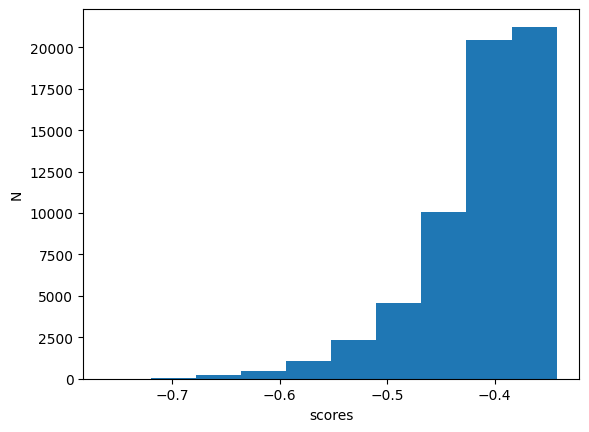

In [31]:
plt.hist(scores_if)
plt.xlabel('scores')
plt.ylabel('N')
plt.show()

In [32]:
# get the 100 most anomalous objects
order_if = np.argsort(scores_if)

In [33]:
# get labels for 500 most anomalous objects (big number to compare with Astronomaly)
labels_if = data_use3['anomaly'].values[order_if[:500]]

In [20]:
x = np.arange(500)

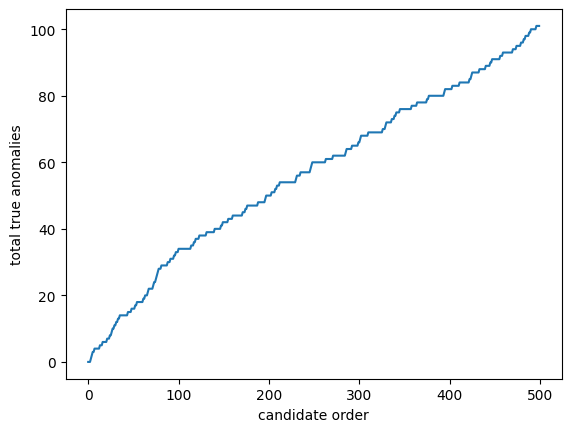

In [35]:
# plot the result in order

y_if = [sum(labels_if[:i]) for i in range(len(labels_if))]

plt.figure()
plt.plot(x,y_if)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
#plt.ylim(0,30)
plt.show()

Something between 5 and 6 is consistent with the first version of this exercise, which is in the overleaf

In [34]:
# run 100 in a role
n = 100

In [37]:
y_if_all = []

for i in progressbar(range(n)):
    model_temp_if = IsolationForest(random_seed=np.random.randint(10**9))
    model_temp_if.fit(data_features)
    scores_temp_if = model_temp_if.score_samples(data_features)
    order_temp_if = np.argsort(scores_temp_if)
    labels_temp_if = data_use3['anomaly'].values[order_temp_if[:500]]
    y_temp_if = [sum(labels_temp_if[:i]) for i in range(len(labels_temp_if))]
    y_if_all.append(y_temp_if)

100% (100 of 100) |######################| Elapsed Time: 0:00:23 Time:  0:00:230002


In [38]:
y_if_all = np.array(y_if_all)

In [39]:
np.save("../data/isoforest_galaxyzoo_" + str(n) + "runs.npy", y_if_all)

In [23]:
y_if_all = np.load("../data/isoforest_galaxyzoo_" + str(100) + "runs.npy")

In [24]:
# get numbers for plotting
ymax_if = [np.percentile(y_if_all[:,i],95) for i in range(y_if_all.shape[1])]
ymin_if = [np.percentile(y_if_all[:,i], 5) for i in range(y_if_all.shape[1])]
ymedian_if = [np.median(y_if_all[:,i]) for i in range(y_if_all.shape[1])]

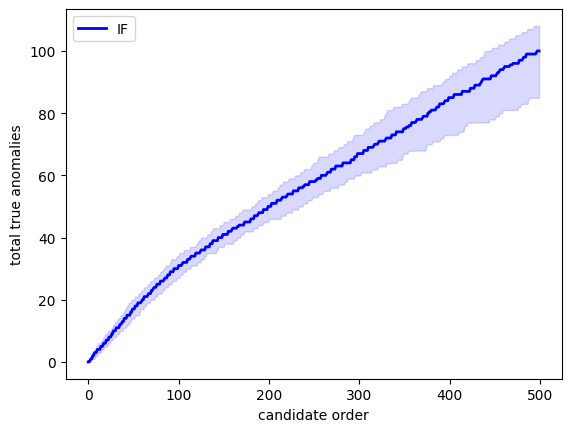

In [25]:
# plot intervals

x = np.arange(len(ymax_if))

plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
#plt.ylim(0,30)
plt.legend()
plt.show()

## PineForest

In [29]:
# set up to use already known labels
def my_on_refit_callback(session):
    #print('Refitting model with known labels:')
    #print(session.known_labels)
    return None

def my_decision_callback(metadata, data, session):
    """Get data from the known table."""
    return Label.ANOMALY if metadata[1] else Label.REGULAR

def my_on_decision_callback(metadata, data, session):
    #print(f'Decision made for {metadata}: {session.last_decision}.')
    return None

class RecordCallback:
    def __init__(self):
        self.records = []

    def __call__(self, metadata, data, session):
        self.records.append(f'{metadata} -> {session.last_decision}')

    def print_report(self):
        #print('Records:')
        #print('\n'.join(self.records))
        return None

In [35]:
record_callback_pine = RecordCallback()

metadata = data_use3[list(data_use3.keys())[-2:]]
model_pine = PineForest(random_seed=42)
nloops = 500           # number of loops 

In [49]:
session_pine = Session(
    data=data_features,
    metadata=metadata,
    model=model_pine,
    decision_callback=my_decision_callback,
    # We can give an only function/callable as a callback
    on_refit_callbacks=my_on_refit_callback,
    # Or a list of callables
    on_decision_callbacks=[
        my_on_decision_callback,
        record_callback_pine,
        TerminateAfter(nloops),
    ],
)
session_pine.run()

In [50]:
labels_pine = [list(session_pine.known_labels.values())[i] == Label.ANOMALY 
               for i in range(nloops)]

In [51]:
y_pine = [sum(labels_pine[:i]) for i in range(len(labels_pine))]

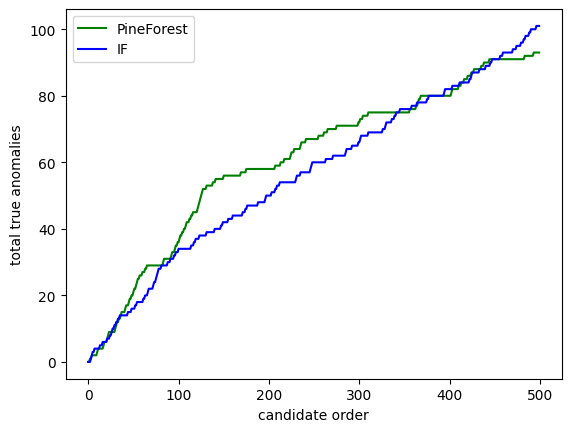

In [52]:
# plot 1 instance

plt.figure()
plt.plot(x, y_pine, color='green', label='PineForest')
plt.plot(x, y_if, color='blue', label='IF')
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
#plt.ylim(0,30)
plt.legend()
plt.show()

In [ ]:
# do it 100 times
n_cores = 15
n = 100
def pineforest_run(data, metadata, seed):
    """Train, evaluate and save results from the model."""
    
    model_temp_pine = PineForest(random_seed=seed)  
    record_callback_temp_pine = RecordCallback()

    session_temp_pine = Session(
        data=data_features,
        metadata=metadata,
        model=model_temp_pine,
        decision_callback=my_decision_callback,
        # We can give an only function/callable as a callback
        on_refit_callbacks=my_on_refit_callback,
        # Or a list of callables
        on_decision_callbacks=[
            my_on_decision_callback,
            record_callback_temp_pine,
            TerminateAfter(nloops),
        ],
    )
    session_temp_pine.run()
    labels_temp_pine = [list(session_temp_pine.known_labels.values())[i] == Label.ANOMALY 
                        for i in range(nloops)]
    y_temp_pine = [sum(labels_temp_pine[:i]) for i in range(len(labels_temp_pine))]

    return y_temp_pine

result =[]
seeds = [np.random.randint(10**9) for i in range(n)]

with ProcessPoolExecutor(max_workers=n_cores) as exe:
    exe.submit(pineforest_run, data_use3, metadata)
        
    # Maps the realization with a iterable
    result = list(exe.map(pineforest_run, repeat(data_use3), repeat(metadata), seeds))


In [ ]:
y_pine_all = np.array(result)

In [ ]:
# save to file
np.save("../data/pineforest_galaxyzoo_" + str(n) + "runs.npy", y_pine_all)

In [22]:
fnames = glob("../data/pineforest_galaxyzoo_" + str(10) + "runs_*.npy")

In [24]:
data_list = []
for fname in fnames:
    data_list.append(np.load(fname))

In [28]:
y_pine_all = np.array(data_list).reshape(100,500)

In [16]:
y_pine_all = np.load('../data/pineforest_galaxyzoo_' + str(100) + 'runs.npy')

In [17]:
y_pine_all.shape

(100, 500)

In [18]:
# get numbers for plotting
ymax_pine = [np.percentile(y_pine_all[:,i],95) for i in range(y_pine_all.shape[1])]
ymin_pine = [np.percentile(y_pine_all[:,i], 5) for i in range(y_pine_all.shape[1])]
ymedian_pine = [np.median(y_pine_all[:,i]) for i in range(y_pine_all.shape[1])]

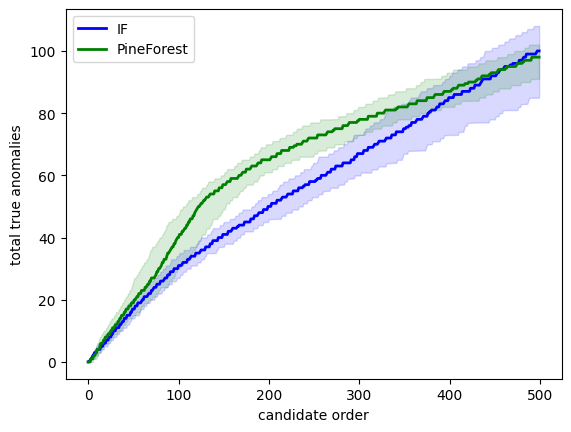

In [26]:
# plot intervals

plt.figure()
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.plot(x, ymedian_pine, color='green', lw=2, label='PineForest')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
ax.fill_between(x, ymin_pine, ymax_pine, color='green', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
#plt.ylim(0,40)
plt.legend()
plt.show()

## AAD

In [ ]:
model_aad = AADForest(random_seed=42)
record_callback_aad = RecordCallback()

session_aad = Session(
    data=data_features,
    metadata=metadata,
    model=model_aad,
    decision_callback=my_decision_callback,
    # We can give an only function/callable as a callback
    on_refit_callbacks=my_on_refit_callback,
    # Or a list of callables
    on_decision_callbacks=[
        my_on_decision_callback,
        record_callback_aad,
        TerminateAfter(nloops),
    ],
)
session_aad.run()

In [ ]:
labels_aad = [list(session_aad.known_labels.values())[i] == Label.ANOMALY for i in range(nloops)]

In [ ]:
y_aad = [sum(labels_aad[:i]) for i in range(len(labels_aad))]

In [ ]:
# plot 1 instance

plt.figure()
plt.plot(x, y_pine, color='green', label='PineForest')
plt.plot(x, y_if, color='blue', label='IF')
plt.plot(x, y_aad, color='orange', label='AAD')
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,30)
plt.legend()
plt.savefig('galaxyzoo.png')

In [ ]:
def aad_run(data, metadata, seed):
    """Train, evaluate and save results from the model."""
    
    model_temp_aad = AADForest(random_seed=seed, n_jobs=1)  
    record_callback_temp_aad = RecordCallback()

    session_temp_aad = Session(
        data=data_features,
        metadata=metadata,
        model=model_temp_aad,
        decision_callback=my_decision_callback,
        # We can give an only function/callable as a callback
        on_refit_callbacks=my_on_refit_callback,
        # Or a list of callables
        on_decision_callbacks=[
            my_on_decision_callback,
            record_callback_temp_aad,
            TerminateAfter(nloops),
        ],
    )
    session_temp_aad.run()
    labels_temp_aad = [list(session_temp_aad.known_labels.values())[i] == Label.ANOMALY 
                        for i in range(nloops)]
    y_temp_aad = [sum(labels_temp_aad[:i]) for i in range(len(labels_temp_aad))]

    return y_temp_aad


In [ ]:
result =[]
seeds = [np.random.randint(10**9) for i in range(n)]

with ProcessPoolExecutor(max_workers=5) as exe:
    exe.submit(aad_run, data_use, metadata)
        
    # Maps the realization with a iterable
    result = list(exe.map(aad_run, repeat(data_features), 
                          repeat(metadata), seeds))

y_aad_all = np.array(result)


In [ ]:
# save to file
np.save("../data/aad_galaxyzoo_" + str(n) + "runs.npy", y_aad_all)

In [ ]:
y_aad_all = np.load('../data/aad_galaxyzoo_200runs.npy')

In [ ]:
# get numbers for plotting
ymax_aad = [np.percentile(y_aad_all[:,i],95) for i in range(y_aad_all.shape[1])]
ymin_aad = [np.percentile(y_aad_all[:,i], 5) for i in range(y_aad_all.shape[1])]
ymedian_aad = [np.median(y_aad_all[:,i]) for i in range(y_aad_all.shape[1])]

In [ ]:
# plot intervals

plt.figure()
plt.suptitle('Galaxy Zoo')
ax = plt.subplot(1,1,1)
ax.plot(x, ymedian_if, color='blue', lw=2, label='IF')
ax.plot(x, ymedian_pine, color='green', lw=2, label='PineForest')
ax.plot(x, ymedian_aad, color='orange', lw=2, label='AAD')
ax.fill_between(x, ymin_if, ymax_if, color='blue', alpha=0.15)
ax.fill_between(x, ymin_pine, ymax_pine, color='green', alpha=0.15)
ax.fill_between(x, ymin_aad, ymax_aad, color='orange', alpha=0.15)
plt.xlabel('candidate order')
plt.ylabel('total true anomalies')
plt.ylim(0,40)
plt.legend()
plt.savefig('galaxyzoo.pdf')